In [5]:

import numpy as np
import datetime as dt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
# from mpl_toolkits.basemap import Basemap
import glob
from netCDF4 import Dataset
import copy
import gc

import os
import sys
# sys.path.insert(0, '/Users/h/Github/geo_data_group/')
import grid_set as gs

import ant_plus
from imp import reload
reload(ant_plus)
reload(gs)

<module 'grid_set' from '/Users/h/PREMELT/Ant+/grid_set.py'>

In [6]:
#$### map projection
m = ccrs.SouthPolarStereo()
proj_cart = ccrs.PlateCarree() 
f = plt.figure()
G= gs.grid_set(m)

ax = f.add_subplot(1,1,1,projection=m)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
G.set_grid_dxy(50e3,50e3,ax)
plt.close()


Got a grid res =  185  x  185
Note that all grid info is in nx x ny grids, whilst data is in nx x ny


In [7]:
file = 'Example_Merge/Open_ocean_ANOM_2019-09-01T00-03_2019-09-03T23-26.nc'
track=ant_plus.CS2_track(file,add_attr=True)
track.print_time()

2019-09-01T00:03:28.418137--2019-09-03T23:26:34.553547


In [8]:
### makes a directory for figures
fig_dir = file.split('.nc')[0]+'/'
check_dir = os.path.dirname(fig_dir)
if not os.path.exists(check_dir):
    os.makedirs(check_dir)

In [9]:
track.list_vars()#['ANOM','flag',])

['time_20_ku',
 'lon_20_ku',
 'lat_20_ku',
 'range_1_20_ku_ANOM_CLS_LEAD',
 'range_1_20_ku_ANOM_MSSL_D',
 'range_1_20_ku_ANOM_MSSL_S',
 'range_1_20_ku_ANOM_DTU_gauss',
 'range_1_20_ku_ANOM_DTU_th70',
 'range_1_20_ku_ANOM_DTU_imp_th70',
 'mean_sea_surf_20_ku_ANOM_DTU15',
 'ocean_tide_20_ku_ANOM_DTU_fes',
 'range_1_20_ku_ANOM_ISat_2step',
 'atm_geo_corrections_sum_ANOM_ISat']

In [10]:
load_list = track.list_vars(['ANOM','flag','height','geoid'])
# load_list = track.list_vars(['mean'])
track.add_vars(load_list)

In [12]:
# track.mean_sea_surf_20_ku_ANOM_DTU15_attr
track.range_1_20_ku_ANOM_CLS_LEAD_attr

{'Description': 'Anomaly from L2 range to CLS range',
 'coordinates': 'lon_poca_20_ku lat_poca_20_ku',
 'Units': 'm'}

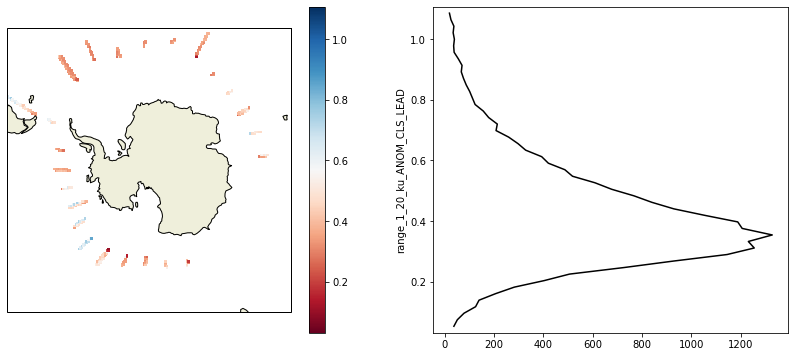

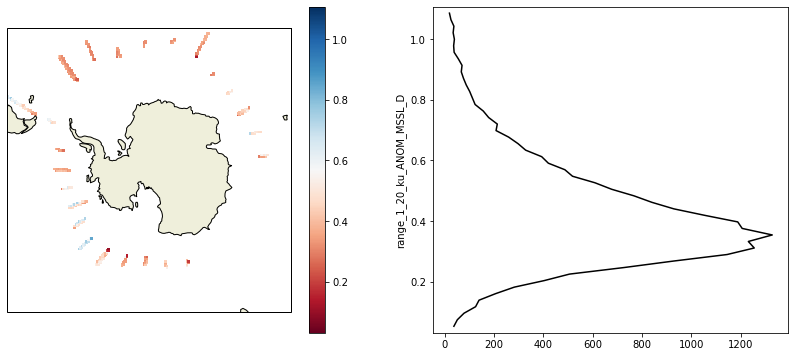

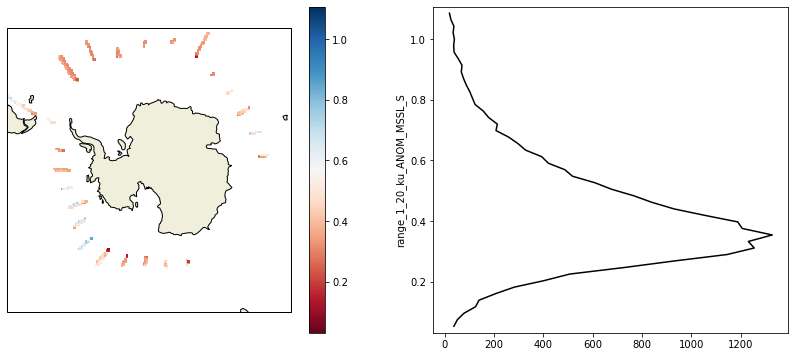

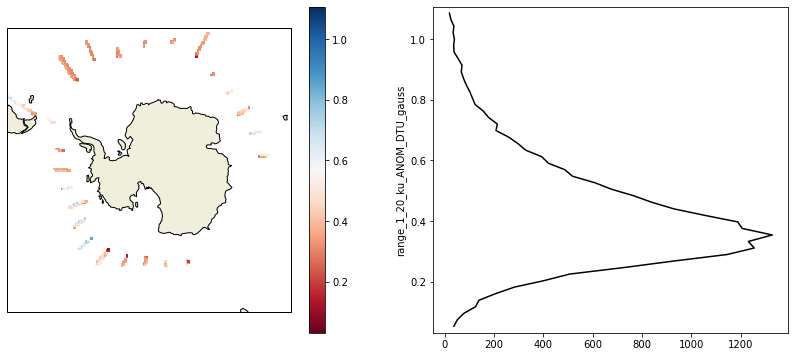

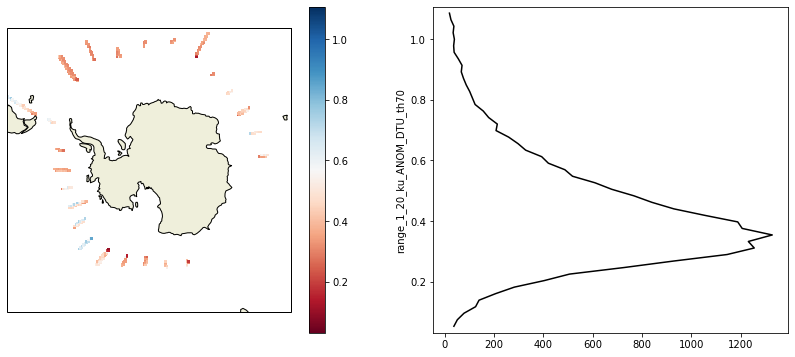

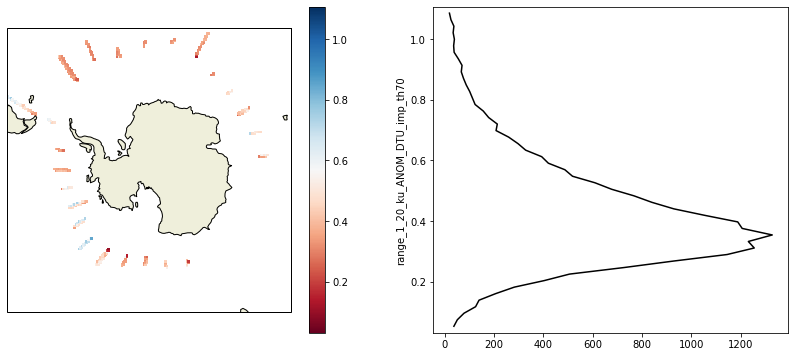

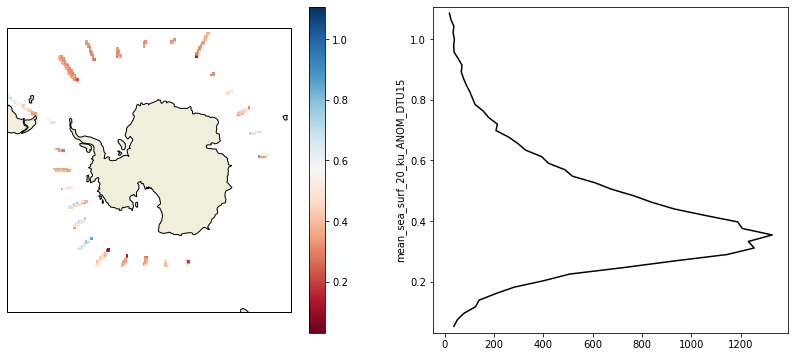

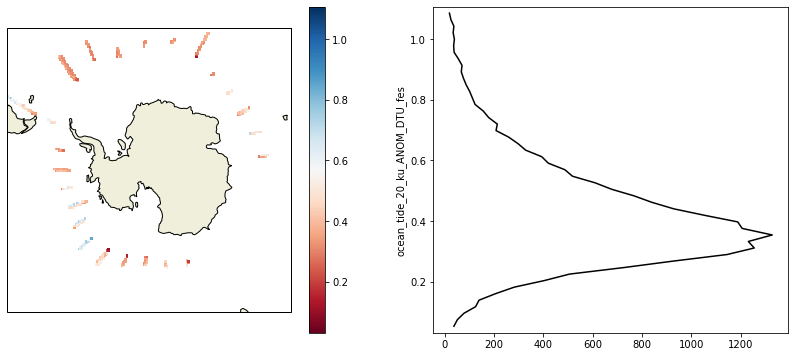

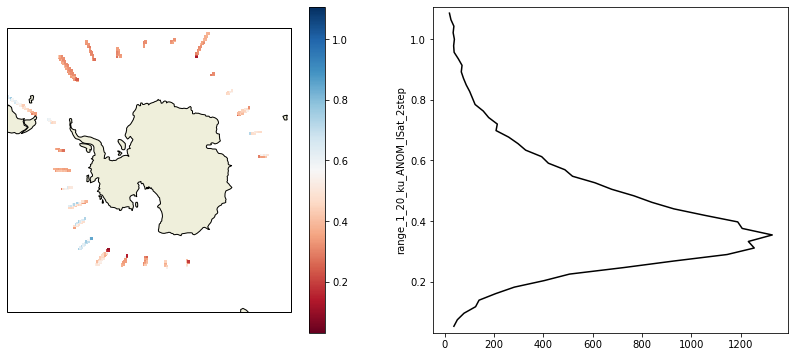

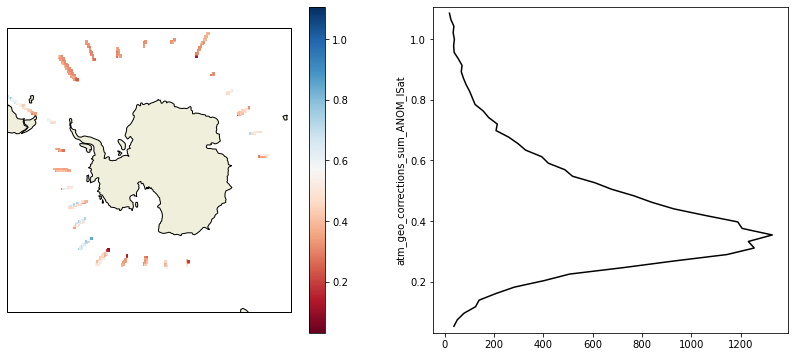

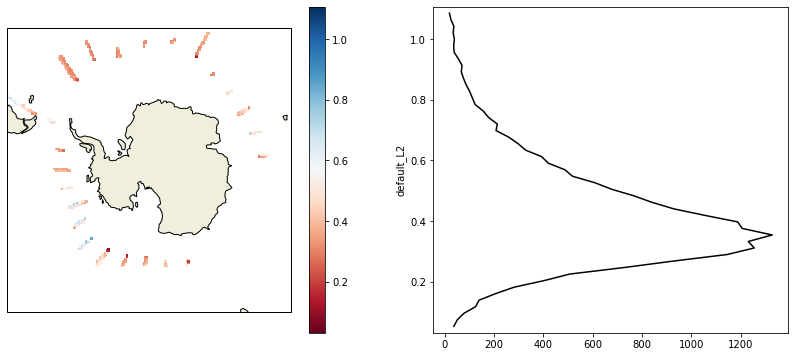

In [16]:
# p_vars = [p for p in track.vars if 'LEGOS' in p and 'flag' not in p]
p_vars = [p for p in track.vars if 'ANOM' in p ]
# p_vars = [p for p in track.vars if 'DTU' in p and 'LEGOS' not in p]
# p_vars = [p for p in track.vars if 'flag' in p]
# p_vars = [p for p in track.vars if 'atm' in p and 'flag' not in p]
SaveT = 'DOT_' ### name for the figure
# p_vars = p_vars+['default_L2'] #### extra for not adding an anomally
h_auto = True ## h_(min,max) calculated from data range
h_sym = False ## h_(min,max) forced to symmetric about 0
h_trim = False ### centiles to knock off, set the percentiles to remove
# h_trim = 5 ### takes away the 5 and 95 percentile before binning/histogram
# h_min = -2.5
# h_max =  0.0
# h_min = 0.9
# h_max =  3.1
hard_min = -10.0 ### extras to remove crazy outliers
hard_max =  10.0
#### surface type options
LG_CLS_flag = 2 ### for CLS and legos 2 => sea_ice
#### a mask is always require from Bl-D L2
msk = np.ones_like(track.time_20_ku,dtype=bool) ### all data
# msk = track.flag_surf_type_class_20_ku ==  128 ### sea ice
# msk[track.flag_surf_type_class_20_ku ==  64] = True ### also ocean
h_bins = np.arange(h_min,h_max,0.02)
for v in p_vars:
#     x = getattr(track,v).copy()
#     if 'default' in v: #### to make DOT
#         x = track.height_1_20_ku - track.geoid_20_ku
#     else:
#         x = getattr(track,v).copy()
#         #### to make DOT
#         x = x + track.height_1_20_ku - track.geoid_20_ku
    #### extra masking
#     if 'GPOD' in v:
#         msk[track.flag_surf_type_20_ku_LEGOS_GPOD==LG_CLS_flag] = 0
#     if 'CLS' in v:
#         msk[track.flag_surf_type_20_ku_CLS==LG_CLS_flag] = 0
#     if 'class' in v:
#         x[x<64] = 0
#         x[x==256] = 3
#         x[x==128] = 2
#         x[x==64] = 1
    x[x.mask] = np.nan
    msk[x>hard_max] = 0
    msk[x<hard_min] = 0
    if h_trim:
        h_t0,h_t1 = np.nanpercentile(x[msk],[h_trim,100-h_trim])
        msk[x>h_t1] = 0
        msk[x<h_t0] = 0
        
    x = x[msk]
        
    plot_array  = G.bin_list(x,#track.mean_sea_surf_20_ku_ANOM_LEGOS_GPOD_DTU15,
                            track.lon_20_ku[msk],track.lat_20_ku[msk],xy_order=0)
#                              bin_func = func_u)
    if h_auto:
        h_min,h_max = np.nanpercentile(x,[0.5,99.5])
        if h_sym:
            h_max = np.maximum(np.abs(h_min),np.abs(h_max))
            h_min = -h_max
        h_bins = np.arange(h_min,h_max,(h_max-h_min)/50)

    f = plt.figure(figsize=[14,6])
    ax = f.add_subplot(1,2,1,projection=m)
    ax.set_extent([-180, 180, -90, -50], proj_cart)
    s = ax.pcolormesh(G.xpts,G.ypts,plot_array,
                     cmap = 'RdBu',vmin = h_min,vmax = h_max)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    plt.colorbar(s,shrink=1.0,pad=0.05)
    
    ax = f.add_subplot(1,2,2)
    hist = np.histogram(x,bins=h_bins)[0]
#     ax.plot(h_bins[:-1] + np.diff(h_bins),hist,'-k')
    ax.plot(hist,h_bins[:-1] + np.diff(h_bins),'-k')
    ax.set_ylim([h_min,h_max])
    ax.set_ylabel(v)
#     f.savefig(fig_dir+SaveT+v+'_map_hist.png',bbox_inches='tight')

    plt.show()

In [19]:
for v in track.vars:
    if 'range' in v and 'ANOM' in v:
#     if 'range' in v and 'ISat' in v:
#     if 'geoi' in v:
#     if 'ANOM' in v:
        print('-----')
        print(v)
        print('-----')
        if hasattr(track,v+'_attr'):
            attr = getattr(track,v+'_attr')
            for key, value in attr.items():
                print(key, ' : ', value)
        x = copy.copy(getattr(track,v))
        if type(x.mask) == np.ndarray:
            x[x.mask] = np.nan
        print('Distribution of '+v+' = '+' , '.join('{:.3}'.format(pc) for pc in np.nanpercentile(x,[25,50,75])))

-----
range_1_20_ku_ANOM_CLS_LEAD
-----
Description  :  Anomaly from L2 range to CLS range
coordinates  :  lon_poca_20_ku lat_poca_20_ku
Units  :  m
Distribution of range_1_20_ku_ANOM_CLS_LEAD = 0.296 , 0.383 , 0.506
-----
range_1_20_ku_ANOM_MSSL_D
-----
Description  :  Anomaly from L2 range to MSSL Diffuse retracker range
coordinates  :  lon_poca_20_ku lat_poca_20_ku
Units  :  m
Distribution of range_1_20_ku_ANOM_MSSL_D = -0.01 , 0.036 , 0.086
-----
range_1_20_ku_ANOM_MSSL_S
-----
Description  :  Anomaly from L2 range to MSSL Spectral retracker range
coordinates  :  lon_poca_20_ku lat_poca_20_ku
Units  :  m
Distribution of range_1_20_ku_ANOM_MSSL_S = 0.398 , 0.514 , 0.681
-----
range_1_20_ku_ANOM_DTU_gauss
-----
Description  :  Anomaly from L2 range to DTU_guass retracker range
coordinates  :  lon_poca_20_ku lat_poca_20_ku
Units  :  m
Distribution of range_1_20_ku_ANOM_DTU_gauss = 0.882 , 1.18 , 1.62
-----
range_1_20_ku_ANOM_DTU_th70
-----
Description  :  Anomaly from L2 range to DTU_